<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Implementation_of_Compact_Convolutional_Transformers_(CCT)_on_the_CIFAR_10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compact Convolutional Transformers (CCT) for efficient image classification on the CIFAR-10 dataset

**Author:** [Ashaduzzaman Piash](
https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 19/06/2024
<br>
**Reference:** [Escaping the Big Data Paradigm with Compact Transformers](https://doi.org/10.48550/arXiv.2104.05704)


## Introduction

### **Vision Transformers (ViT)**:
  - **Requirement**: Larger datasets and longer pre-training schedules.
  - **Example**: ImageNet-1k (1 million images) is medium-sized for ViTs.
  - **Reason**: ViTs lack inductive biases (e.g., convolutions in CNNs).

  - **Key Question**:
    - **Possibility**: Combining benefits of convolutions and Transformers.
    - **Benefits**: Parameter-efficiency, self-attention for long-range and global dependencies.

### **Compact Convolutional Transformer (CCT)**:
  - **Proposal**: By Hassani et al. in "[Escaping the Big Data Paradigm with Compact Transformers](https://doi.org/10.48550/arXiv.2104.05704)"
  - **Goal**: Integrate the strengths of convolutional networks and Transformers.

  - **Implementation**:
    - **Dataset**: CIFAR-10.
    - **Performance**: Evaluate CCT's effectiveness on CIFAR-10.

  - **CCT Architecture:**

![](https://www.researchgate.net/publication/361183302/figure/fig2/AS:1164977956233218@1654763797473/Compact-convolutional-transformer-CCT-model-architecture.png)

## Imports

In [1]:
# Update to keras 3
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import layers

## Hyperparameters and Constants

In [3]:
## Configuration for the Compact Convolutional Transformer (CCT)

positional_emb = True    # Use positional embedding
conv_layers = 2          # Number of convolutional layers
projection_dim =128      # Dimensionality of the projection

num_heads = 2            # Number of attention heads in the Transformer

# Units in the Transformer layers
transformer_units = [
    projection_dim,
    projection_dim,
]

transformer_layers = 2   # Number of Transformer layers
stocastic_depth_rate = 0.1   # Rate of stochastic depth (used for regularization)

# Training hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32          # Size of the input images (CIFAR-10)

## Load CIFAR-10 dataset

In [4]:
# Number of classes in the CIFAR-10 dataset
num_classes =10

# Shape of the input images
input_shape = (32, 32, 3)

# Load CIFAR-10 dataset from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Print shapes of the training and test datasets
print(f'x_train shape: {x_train.shape} - y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} - y_test shape: {y_test.shape}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


## The CCT tokenizer

- **Function**: Processes images for the neural network.
- **Comparison**: Standard ViTs use uniform, non-overlapping patches.
- **Advantage**: Preserves boundary-level information between patches.
- **Benefit**: Helps the neural network exploit locality information effectively.
- **Illustration**: Shows how images are organized into patches.

![](https://i.imgur.com/IkBK9oY.png)

In [5]:
class CCTTokenizer(layers.Layer):
  def __init__(
      self,
      kernel_size=3,
      stride=1,
      padding=1,
      pooling_kernel_size=3,
      pooling_stride=2,
      num_conv_layers=conv_layers,
      num_output_channels=[64, 128],
      positional_emb=positional_emb,
      **kwargs,
  ):
      super().__init__(**kwargs)

      # Initialize a sequential model to serve as the tokenizer
      self.conv_model=keras.Sequential()
      for i in range(num_conv_layers):
        self.conv_model.add(
            layers.Conv2D(
                num_output_channels[i],
                kernel_size,
                stride,
                padding='valid',
                use_bias=False,
                activation='relu',
                kernel_initializer='he_normal',
            )
        )
        self.conv_model.add(layers.ZeroPadding2D(padding))
        self.conv_model.add(
            layers.MaxPooling2D(pooling_kernel_size, pooling_stride, 'same')
        )

      # Whether to use positional embeddings
      self.positional_emb = positional_emb

  def call(self, images):
    # Pass the images through the convolutional model
    outputs = self.conv_model(images)

    # Flatten the spatial dimensions to form sequences
    reshaped = keras.ops.reshape(
        outputs,
        (
            -1,    # Keep the batch size the same
            keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],  # Flatten spatial dimensions
            keras.ops.shape(outputs)[-1],  # Keep the number of channels the same
        ),
    )
    return reshaped


## Positional Embeddings

- Positional embeddings are optional in CCT

In [6]:
class PositionEmbedding(keras.layers.Layer):
  def __init__(
      self,
      sequence_length,
      initializer='glorot_uniform',
      **kwargs,
  ):
      super().__init__(**kwargs)
      # Ensure sequence_length is provided
      if sequence_length is None:
        raise ValueError('`sequence_length` must be an Integer, received `None`.')
      self.sequence_length = int(sequence_length)
      self.initializer = keras.initializers.get(initializer)

  def get_config(self):
    # Return the configuration of the layer
    config = super().get_config()
    config.update(
        {
            'sequence_length': self.sequence_length,
            'initializer': keras.initializers.serialize(self.initializer),
        }
    )
    return config

  def build(self, input_shape):
    # Define the position embeddings weight matrix
    feature_size = input_shape[-1]
    self.position_embeddings = self.add_weight(
        name='embeddings',
        shape=[self.sequence_length, feature_size],
        initializer=self.initializer,
        trainable=True,
    )

    super().build(input_shape)

  def call(self, inputs, start_index=0):
    shape = keras.ops.shape(inputs)
    feature_length = shape[-1]
    sequence_length = shape[-2]

    # Convert position_embeddings to tensor and slice to match the input sequence length
    position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
    position_embeddings = keras.ops.slice(
        position_embeddings,
        (start_index, 0),
        (sequence_length, feature_length),
    )
    # Broadcast position embeddings to match the input shape
    return keras.ops.broadcast_to(position_embeddings, shape)

  def compute_output_shape(self, input_shape):
    # Output shape is the same as the input shape
    return input_shape

## Sequence Pooling / Attention pooling

In [7]:
class SequencePooling(layers.Layer):
  def __init__(self):
    super().__init__()
     # Define a Dense layer to compute attention scores
    self.attention = layers.Dense(1)

  def call(self, x):
    # Compute attention weights and apply softmax along the sequence dimension
    attention_weights = keras.ops.softmax(self.attention(x), axis=1)

    # Transpose attention weights for matrix multiplication
    attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))

    # Compute the weighted representation by performing matrix multiplication
    weighted_representation = keras.ops.matmul(attention_weights, x)

    # Squeeze out the single-dimensional entries from the shape
    return keras.ops.squeeze(weighted_representation, -2)

## Stochastic depth for regularization

- **Function**: A regularization technique that randomly drops a set of layers.
- **Inference**: Layers are kept as they are during inference.
- **Comparison**: Similar to Dropout but operates on a block of layers instead of individual nodes.
- **Usage in CCT**: Applied just before the residual blocks of a Transformers encoder.

In [8]:
class StochasticDepth(layers.Layer):
  def __init__(self, drop_prop, **kwargs):
    super().__init__(**kwargs)
    self.drop_prob = drop_prop  # Probability of dropping layers
    self.seed_generator = keras.random.SeedGenerator(42)

  def call(self, x, training=None):
    if training:
      keep_prob = 1 - self.drop_prob  # Probability of keeping layers
      shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1) # Shape for random tensor
      random_tensor = keep_prob + keras.random.uniform(
          shape, 0, 1, seed=self.seed_generator   # Generate random tensor
      )
      random_tensor = keras.ops.floor(random_tensor) # Floor the random tensor to get binary mask
      return (x / keep_prob) * random_tensor  # Scale the input and apply mask
    return x

##  MLP for the Transformers encoder

**MLP Architecture:**

![](https://aiml.com/wp-content/uploads/2022/06/Multilayer-perceptron-MLP.png)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Data Augmentation

In [10]:
data_augmentation = keras.Sequential(
  [
      layers.Rescaling(scale=1.0 / 255),
      layers.RandomCrop(image_size, image_size),
      layers.RandomFlip('horizontal'),
  ],
  name='data_augmentation',
)

## The final CCT model

In [11]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment Data
    augmented = data_augmentation(inputs)

    # Encode Patches
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply Positional Embeddings
    if positional_emb:
      sequence_length = encoded_patches.shape[-1]
      encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
          encoded_patches
      )

    # Calculate Stochastic Depth Probabilities
    dpr = [x for x in np.linspace(0, stocastic_depth_rate, transformer_layers)]

    # Create multiple kayers of the Transformer block
    for i in range(transformer_layers):
      # Layer normalization 1
      x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

      # Create a multihead attention layer
      attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

      # Skip connection 1
      attention_output = StochasticDepth(dpr[i])(attention_output)
      x2 = layers.Add()([attention_output, encoded_patches])

      # Layer normalization 2
      x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

      # MLP
      x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

      # Skip connection 2
      x3 = StochasticDepth(dpr[i])(x3)
      encoded_patches = layers.Add()([x3, x2])

    # Apply Sequence pooling
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs
    logits = layers.Dense(num_classes)(weighted_representation)

    # Create the Keras Model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Model training and evaluation

In [12]:
def run_experiment(model):
  # Initialize the AdamW optimizer with a specified learning rate and weight decay
  optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

  # Compile the model with the optimizer, loss function, and evaluation metrics
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.CategoricalCrossentropy(
          from_logits=True, label_smoothing=0.1
      ),
      metrics=[
          keras.metrics.CategoricalAccuracy(name='accuracy'),
          keras.metrics.TopKCategoricalAccuracy(5, name='top-5-accuracy'),
      ],
  )

  # Define the file path for saving the best model weights
  checkpoint_filepath = '/tmp/checkpoint.weights.h5'

  # Create a callback to save the model's weights
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor='val_accuracy',
      save_best_only=True,
      save_weights_only=True,
  )

  # Train the model with the training data and validation split
  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
  )

  # Load the best weights after training
  model.load_weights(checkpoint_filepath)

  # Evaluate the model on the test data
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

  # Print the test accuracy and top-5 accuracy
  print(f'Test Accuracy: {round(accuracy * 100, 2)}%')
  print(f'Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%')

  return history

# Create the CCT model and run the experiment
cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.2641 - loss: 2.1003 - top-5-accuracy: 0.7470 - val_accuracy: 0.5000 - val_loss: 1.5743 - val_top-5-accuracy: 0.9402
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5123 - loss: 1.5585 - top-5-accuracy: 0.9318 - val_accuracy: 0.6054 - val_loss: 1.3682 - val_top-5-accuracy: 0.9624
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5956 - loss: 1.3816 - top-5-accuracy: 0.9594 - val_accuracy: 0.6240 - val_loss: 1.3482 - val_top-5-accuracy: 0.9576
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6386 - loss: 1.2962 - top-5-accuracy: 0.9642 - val_accuracy: 0.6656 - val_loss: 1.2388 - val_top-5-accuracy: 0.9714
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6740 - loss: 1.2258 - top-5-accuracy: 0.9719 - val_accuracy: 0.7002 - val_loss: 1.1696 - val_top-5-accuracy: 0.9792
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6937 - loss: 1.18

## Visualize the training progress of the model

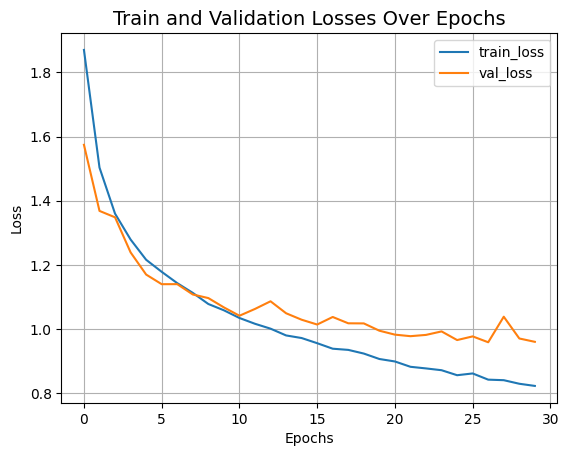

In [13]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs', fontsize=14)
plt.legend()
plt.grid()
plt.show()

## **CCT Model Performance**
  - **Parameters**: 0.4 million.
  - **Accuracy**: ~79% top-1 accuracy in 30 epochs.
  - **Overfitting**: No signs observed; potential for further training with more regularization.
  - **Improvement**: Could be achieved with techniques like cosine decay learning rate, AutoAugment, MixUp, or Cutmix.
  - **Optimal Performance**: Authors report 95.1% top-1 accuracy on CIFAR-10 with these modifications.

### **Comparison with ViT**:
  - **Parameters**: 4.7 million.
  - **Training**: 100 epochs.
  - **Accuracy**: 78.22% top-1 accuracy on CIFAR-10.